# Star wars characters network analysis

Final project for 02805 Social Graphs And Interactions course.

Authors:

* Emilia Konopko
* Barbara Piekarska
* Aleksander Nagaj

Table of contents

1. [Environment preparation](#environment-preparation)
    1. [Data loading](#data-loading)
    

## Environment preparation <a name="environment-preparation"></a>

In [3]:
# standard library
import os
import pickle
import random
import re

# related third-party
import fa2
from matplotlib import (
    cm,
    colors,
)
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
from PIL import Image
import seaborn as sns
from wordcloud import WordCloud

# local
from datautils import datautils
from graph import graph
from sentiment import sentiment
from style import style

base_graph_dir = "graph/"
FA_POSITIONS_ALL = base_graph_dir + "fa_positions_all.pickle"
UNIVERSE_EDGELIST_PATH = base_graph_dir + "universe.edgelist"
GRAPH_UNIVERSE_PATH = base_graph_dir + "universe.pickle"
GRAPH_EPISODES_PATH = base_graph_dir + "universe_episodes.pickle"
FA_POSITIONS_EPISODES = base_graph_dir + "fa_positions_ep.pickle"

SENTIMENT_DATA_PATH = "sentiment/data_with_sentiment.pickle"

### Data loading <a name="data-loading"></a>

In [4]:
loader = datautils.Loader()
loader.load("data/characters/")
data = loader.to_dataframe()
loader.drop()

## Main Network

Network containing all characters, regardless whether they originated from movie, comic, canon or purely fandom creations.

### Creating graphs

* Directed Graph,
* Directed Largest Connected Components Graph
* Undirected Largest Connected Components Graph

In [5]:
if os.path.exists(GRAPH_UNIVERSE_PATH):
    with open(GRAPH_UNIVERSE_PATH, 'rb') as f:
        universe = pickle.load(f)
else:
    universe = graph.create_directed_graph(data)
    # save graph as an edgelist
    nx.write_edgelist(universe, UNIVERSE_EDGELIST_PATH)

    with open(GRAPH_UNIVERSE_PATH, 'wb') as f:
        pickle.dump(universe, f)

In [6]:
style.print_header("Directed graph")
print(f"Number of nodes: {len(universe.nodes)}")
print(f"Number of links: {len(universe.edges)}")
print()

universe_cc = graph.connected_components(universe)
style.print_header("Large Connected Components directed graph")
print(f"Number of nodes: {len(universe_cc.nodes)}")
print(f"Number of links: {len(universe_cc.edges)}")
print()

universe_cc_undirected = universe_cc.to_undirected()
style.print_header("Large Connected Components undirected graph")
print(f"Number of nodes: {len(universe_cc_undirected)}")
print(f"Number of links: {len(universe_cc_undirected.edges)}")

==================== Directed graph ====================

Number of nodes: 29435
Number of links: 91957

==================== Large Connected Components directed graph ====================

Number of nodes: 19080
Number of links: 86586

==================== Large Connected Components undirected graph ====================

Number of nodes: 19080
Number of links: 62704


> For further analysis only Largest Connected Component (LCC) will be used

### Degree distribution

==================== Universe stats ====================

In degree: {'mean': 4.5380503144654085, 'median': 2.0, 'mode': 1, 'min': 0, 'max': 915}
Out degree: {'mean': 4.5380503144654085, 'median': 3.0, 'mode': 1, 'min': 0, 'max': 390}

Calculating best minimal value for power law fit
In degree slope: 2.55


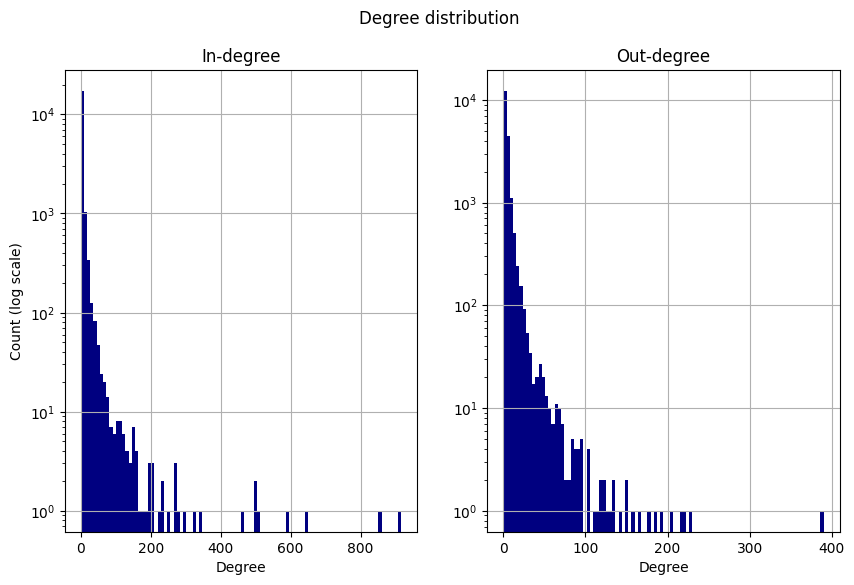

In [7]:
# calculater degree distributions
style.print_header("Universe stats")
in_stats = graph.calc_stats(universe_cc.in_degree())
out_stats = graph.calc_stats(universe_cc.out_degree())
print(f"In degree: {in_stats}")
print(f"Out degree: {out_stats}")

print()
print(f"In degree slope: {graph.power_law_fit(universe_cc):.2f}")    

in_degree, out_degree = graph.plot_degree_distribution(universe_cc, scale='log')

### Largest Connected Component Visualization

Undirected version of graph was used.

[]

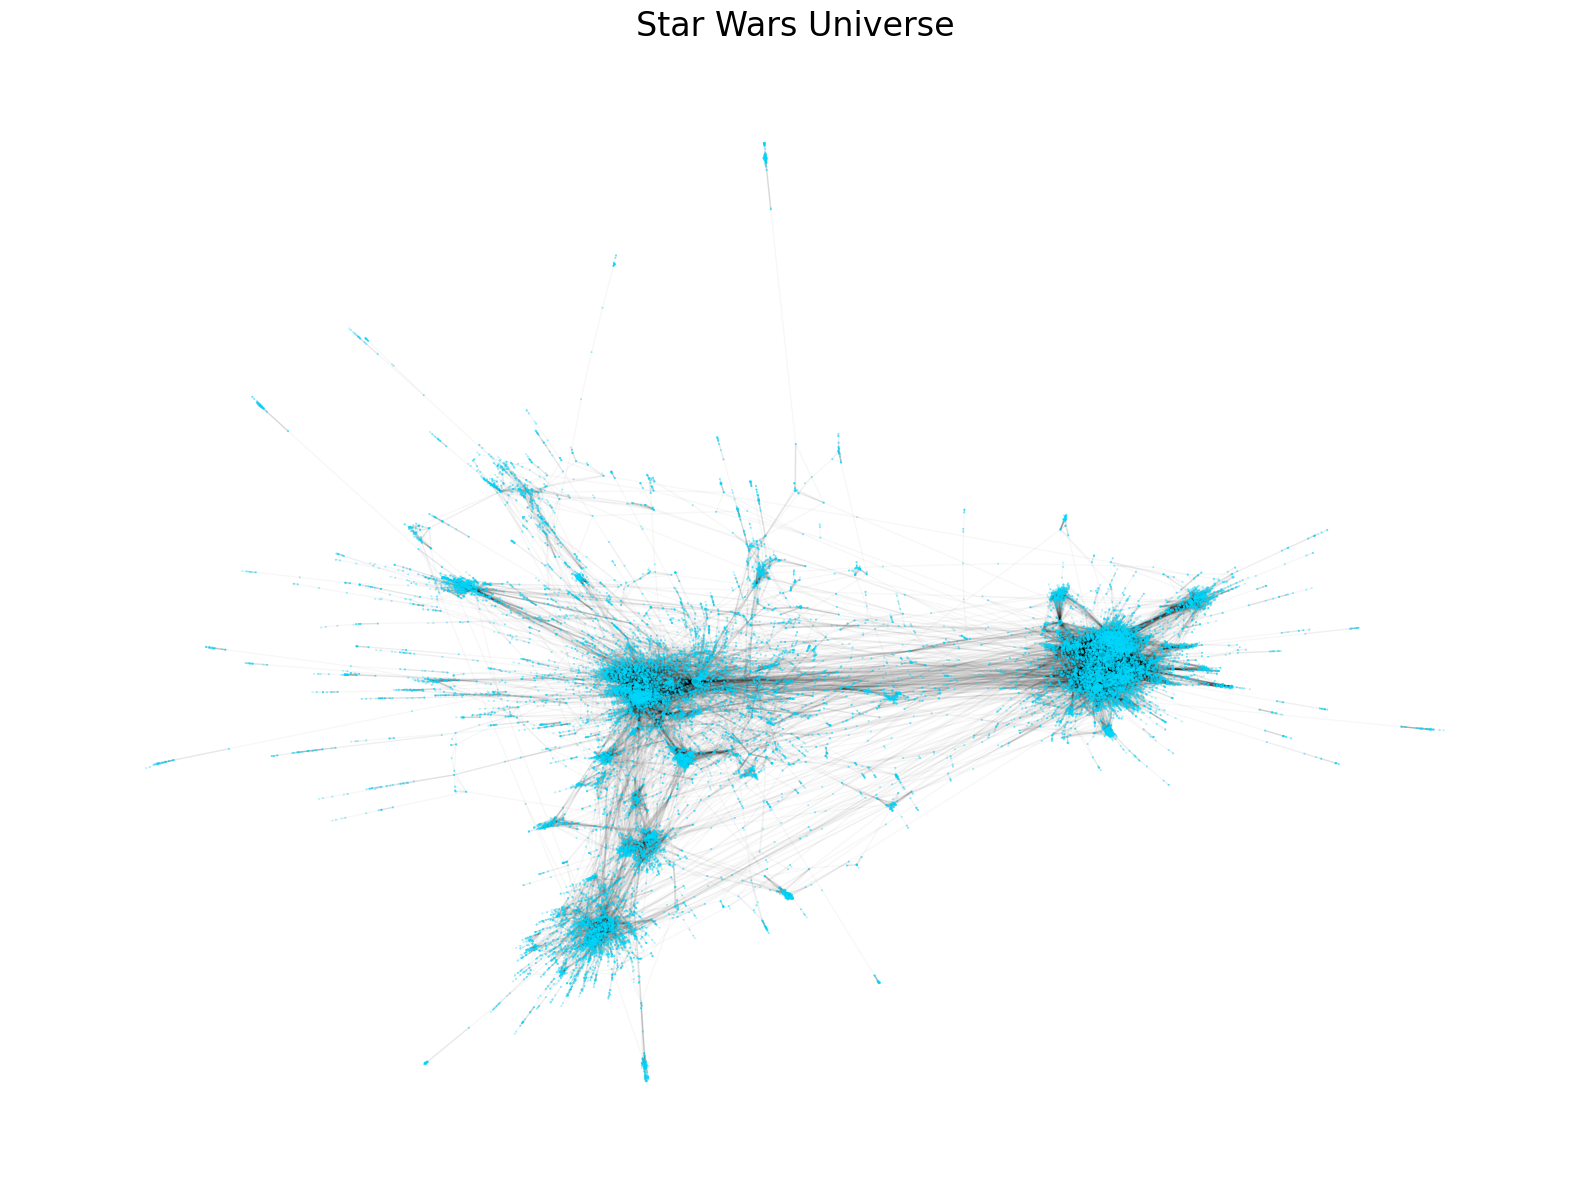

In [8]:
# load pickle with pre-calculated positions if present
if os.path.exists(FA_POSITIONS_ALL):
    with open(FA_POSITIONS_ALL, "rb") as rbfile:
        positions = pickle.load(rbfile)
else:
    positions = fa2.ForceAtlas2(
        verbose=False,
    ).forceatlas2_networkx_layout(
        universe_cc_undirected,
        pos=None,
        iterations=2000,
    )
    # save to pickle for later use
    with open(FA_POSITIONS_ALL, "wb") as wbfile:
        pickle.dump(positions, wbfile)

_ = graph.plot_graph_with_positons(
    universe_cc_undirected,
    positions,
    "Star Wars Universe",
    node_alpha=0.8,
    node_size_factor=0.03,
    edge_alpha=0.03,
    figsize=style.LARGE_FIGSIZE,
)
plt.plot()

### Largest hubs

In [9]:
style.print_header("Characters with the largest number of in degree")
print("{:<4s}{:30s}{}".format("no.", "Character", "In degree"))

in_degree_sorted = np.argsort(in_degree)[::-1]
nodes_list = list(universe_cc.nodes())
for i in range(10):
    character = nodes_list[in_degree_sorted[i]]
    degree = universe_cc.in_degree(character)
    print(f"{i+1:<4d}{data[data.Name == character].DisplayName.values[0]:30s}{degree}")

print()
style.print_header("Characters with the largest number of out degree")
print("{:<4s}{:30s}{}".format("no.", "Character", "Out degree"))

out_degree_sorted = np.argsort(out_degree)[::-1]
for i in range(10):
    character = nodes_list[out_degree_sorted[i]] 
    degree = universe_cc.out_degree(character)
    print(f"{i+1:<4d}{data[data.Name == character].DisplayName.values[0]:30s}{degree}")

==================== Characters with the largest number of in degree ====================

no. Character                     In degree
1   Anakin Skywalker              915
2   Leia Organa Solo              852
3   Darth Sidious                 648
4   Ruwan Tokai                   590
5   Han Solo                      506
6   Obi-Wan Kenobi                501
7   Leia Skywalker Organa Solo    496
8   Luke Skywalker                461
9   Ahsoka Tano                   340
10  Chewbacca                     327

==================== Characters with the largest number of out degree ====================

no. Character                     Out degree
1   Anakin Skywalker              390
2   Obi-Wan Kenobi                229
3   Leia Skywalker Organa Solo    222
4   Darth Caedus                  218
5   Ahsoka Tano                   204
6   Corran Horn                   194
7   Jaina Solo Fel                186
8   Mitth'raw'nuruodo             178
9   Han Solo                      164
10  L

Wookiepedia contains two pages for princess Leia character. It was decided to proceed with analysis with both of them, because both articles are rich in content.

1. [Leia Skywalker Organa Solo](https://starwars.fandom.com/wiki/Leia_Skywalker_Organa_Solo?so=search)
2. [Leia Organa Solo](https://starwars.fandom.com/wiki/Leia_Organa_Solo)

In [10]:
# Leia character is repeated in the data
data[data.Name.isin(["Leia_Skywalker_Organa_Solo", "Leia_Organa_Solo"])]

Name                 DisplayName  \
13420            Leia_Organa_Solo            Leia Organa Solo   
13421  Leia_Skywalker_Organa_Solo  Leia Skywalker Organa Solo   

                                                 Content  \
13420  Leia Organa Solo , a Force-sensitive Human fem...   
13421  Leia Skywalker Organa Solo was a Force-sensiti...   

                                              Crosslinks Species  Gender  \
13420  [Star_Wars_Legends, Wookieepedia:Featured_arti...   Human  Female   
13421  [Canon, Leia_Skywalker_Organa_Solo, Leia_Organ...   Human  Female   

                                          Affiliation(s) Homeworld  \
13420  [Galactic Empire, House Organa, Alderaanian Re...  Alderaan   
13421  [Skywalker family, Elder Houses, House of Orga...  Alderaan   

                                 Died  
13420  [0 ABY, Bedlam, 2 ABY, Mimban]  
13421            [35 ABY, Ajan Kloss]

### Finding communities in the universe

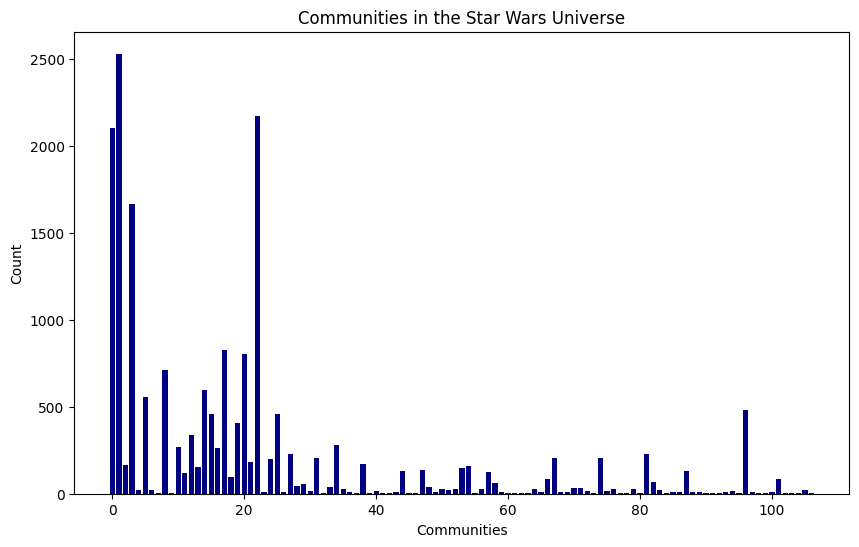

In [11]:
partition, communities, mod = graph.find_communities(universe_cc_undirected)
graph.plot_distribution(
    communities.keys(),
    communities.values(),
    title="Communities in the Star Wars Universe",
    xlabel="Communities",
)

In [12]:
# separate only communities with the size larger than 500 to color them
biggest_communities = []

for key, val in communities.items():
    if val > 500:
        biggest_communities.append(key)

biggest_communities_node = dict()
for key, val in partition.items():
    if val in biggest_communities:
        biggest_communities_node[key] = val

data_biggest_communities = data.loc[data['Name'].isin(biggest_communities_node.keys())].reset_index(drop=True)

partition_biggest_communities = []
for n in data_biggest_communities.Name:
    partition_biggest_communities.append(biggest_communities_node[n])

In [13]:
sns_colors = sns.color_palette("tab10").as_hex()

colors_dict = dict()
for i, c in enumerate(biggest_communities):
    colors_dict[c] = sns_colors[i]

color_map = []

for i in partition.values():
    if i in biggest_communities:
        color_map.append(colors_dict[i])
    else:
        color_map.append('lightgrey')

Visualization of the universe with coloring of communities having more than 500 members/

<AxesSubplot: title={'center': 'Star Wars Communities'}>

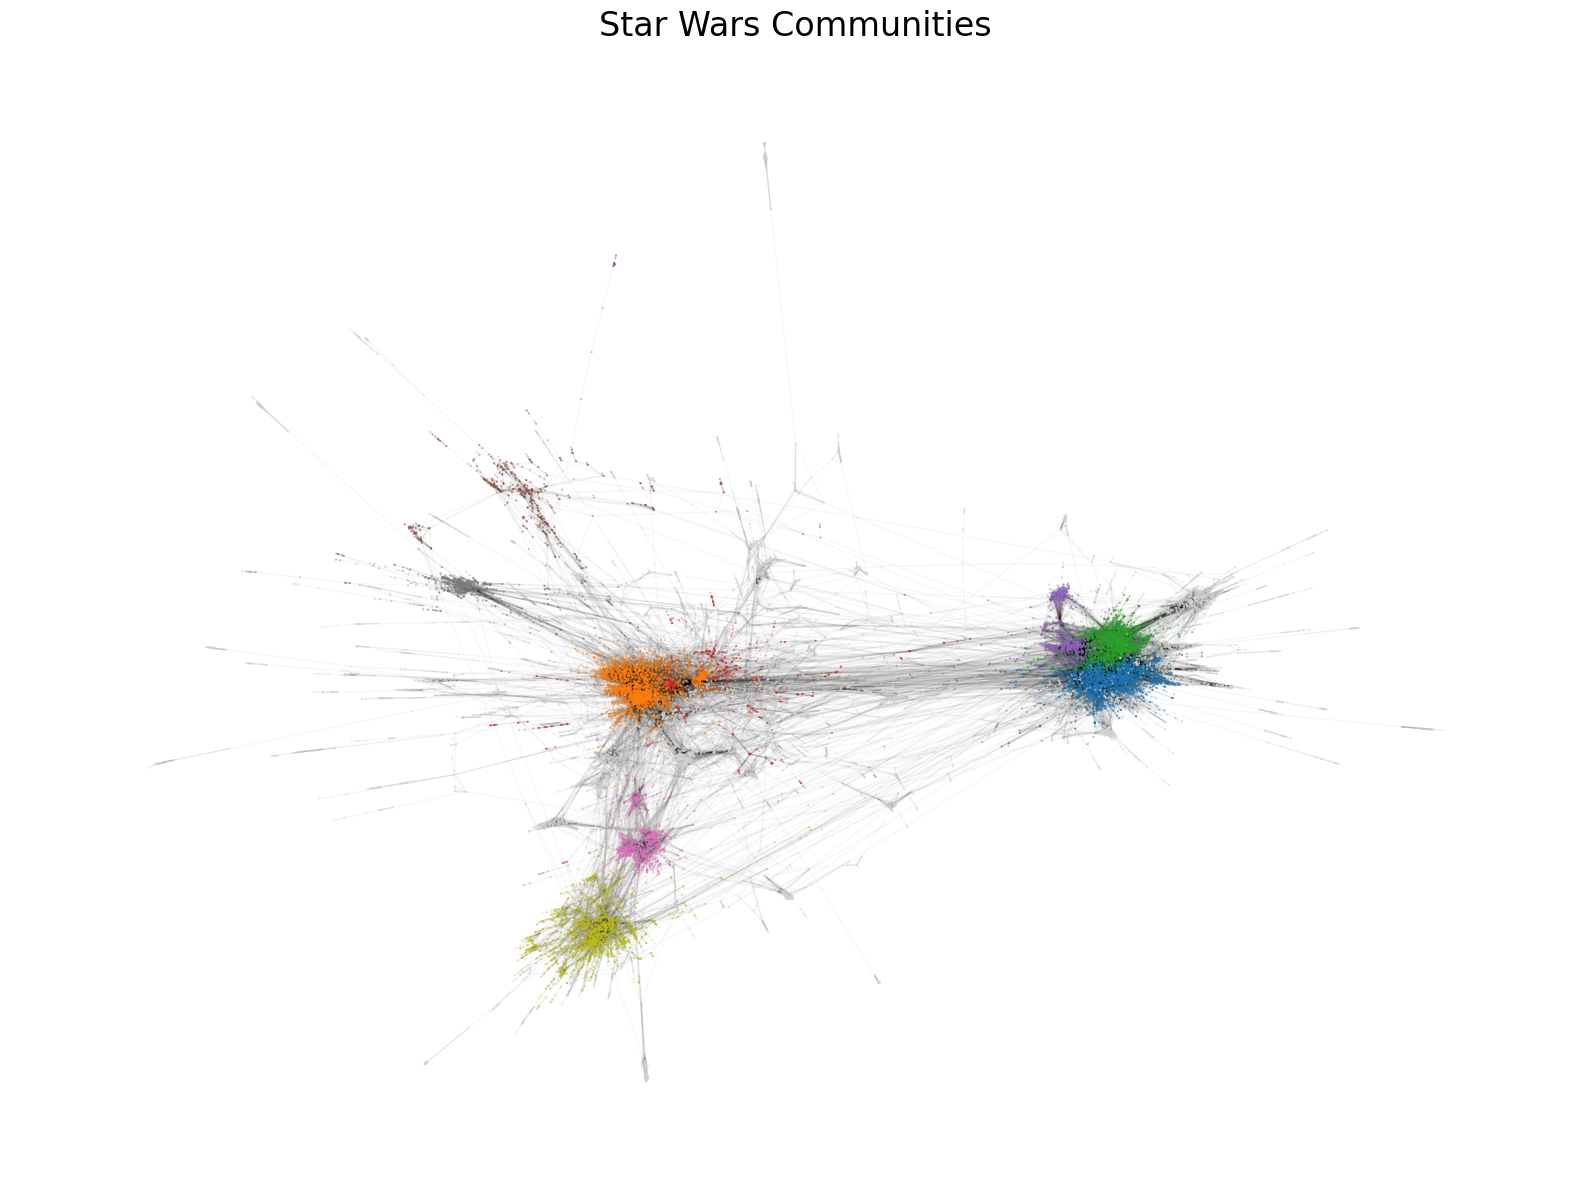

In [14]:
node_degrees = sorted(universe_cc_undirected.degree, key=lambda x: x[1], reverse=True)

graph.plot_graph_with_positons(
    universe_cc_undirected,
    positions,
    "Star Wars Communities",
    node_color=color_map,
    node_alpha=0.8,
    node_size_factor=0.03,
    edge_alpha=0.03,
    figsize=style.LARGE_FIGSIZE,
)

## Outlier analysis

In [15]:
outliers = [node for node in universe.nodes() if universe.degree(node) == 0]
print(f"There are {len(outliers)} nodes without any edges, which were defined as outliers.")

There are 6462 nodes without any edges, which were defined as outliers.


In [16]:
outliers_data = data.loc[data['Name'].isin(outliers)]
outliers_data.head()

Name          DisplayName  \
0   %22Blue%22_Imcrix        "Blue" Imcrix   
1  %22Fugitive%22_Fod       "Fugitive" Fod   
3  %27Ndranth_Poussan     'Ndranth Poussan   
4                0761                 0761   
7  1138_(First_Order)  1138  (First Order)   

                                             Content  \
0  "Blue" Imcrix was an infamous male Taloron cri...   
1  "Fugitive" Fod was a male Yuzzum from Endor wh...   
3  'Ndranth Poussan was a Human male starfighter ...   
4  0761 was a stormtrooper who was stationed on C...   
7  1138 was a human male stormtrooper who served ...   

                                          Crosslinks  Species Gender  \
0  [Star_Wars_Legends, Taloron, Gender/Legends, C...  Taloron   Male   
1  [Star_Wars_Legends, Endor/Legends, Yuzzum/Lege...   Yuzzum   Male   
3  [Star_Wars_Legends, Wookieepedia:Good_articles...    Human   Male   
4  [Star_Wars_Legends, 5_ABY/Legends, Ciutric_IV,...    Human   Male   
7  [Canon, 1138, Special:Upload, Human, Gender, F...    Human   Male   

                                      Affiliation(s) Homeworld  \
0                                                NaN       NaN   
1                                                NaN     Endor   
3  [Agamar Resistance, Alliance to Restore the Re...    Agamar   
4  [Galactic EmpireStormtrooper Corps, Stormtroop...       NaN   
7  [First Order, Stormtrooper Corps, Stormtrooper...       NaN   

                   Died  
0                   NaN  
1                   NaN  
3  [1 BBY, near Brigia]  
4   [5 ABY, Ciutric IV]  
7                   NaN

Most of the outliers are linked with "Legends" articles.

In [17]:
outliers_data["Crosslinks"].explode().value_counts()

Star_Wars_Legends              5850
Gender/Legends                 5306
Human/Legends                  2855
Color/Legends                  2334
Wookieepedia:Stub              2176
                               ... 
Hammer_Station                    1
Battle_station                    1
Mechanical_Liberation_Front       1
MerenData/Legends                 1
Challenge_37                      1
Name: Crosslinks, Length: 16883, dtype: int64

Most of the outliers are either members of Republic or Empire. Which may indicate that these are generic characters, such as stormtroopers or soldiers, who had their little episode. Not necessairly meainingful.

In [18]:
outliers_data["Affiliation(s)"].dropna().explode().value_counts()

Galactic Republic                    622
Sith Empire                          487
Galactic Empire                      471
Alliance to Restore the Republic     301
Jedi Order                           269
                                    ... 
Edan Spaceways                         1
Corellian Shipbuilders Union           1
Galactic EmpireMoff Lasre Dardano      1
Moff Lasre Dardano                     1
Rebel AllianceArdan resistance         1
Name: Affiliation(s), Length: 1476, dtype: int64

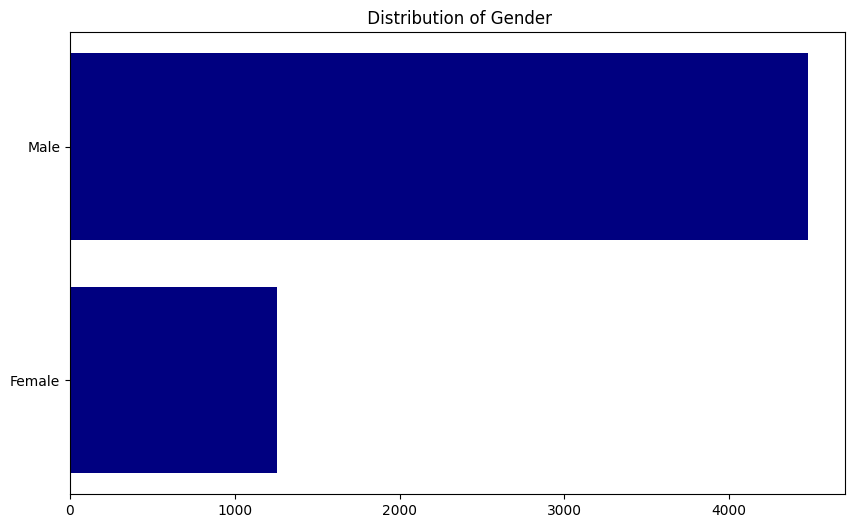

In [19]:
datautils.plot_series_distribution(outliers_data["Gender"], 2)

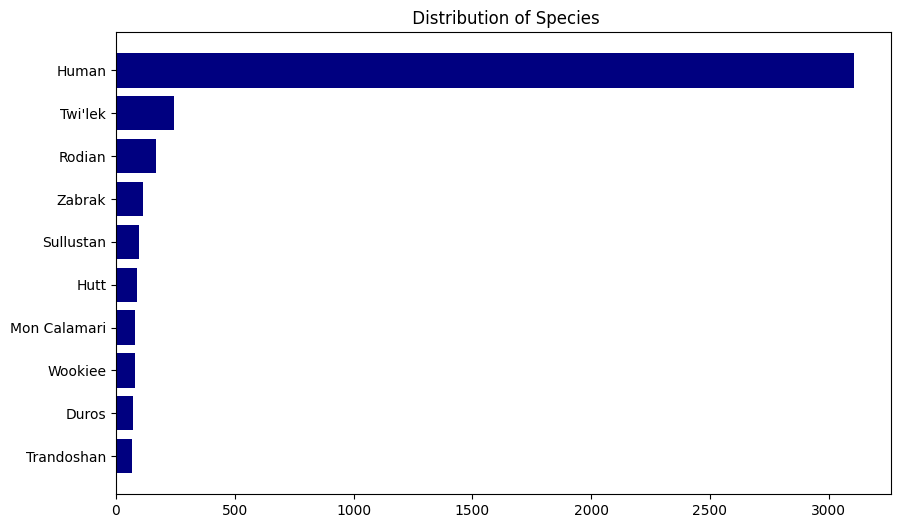

In [20]:
datautils.plot_series_distribution(outliers_data["Species"])

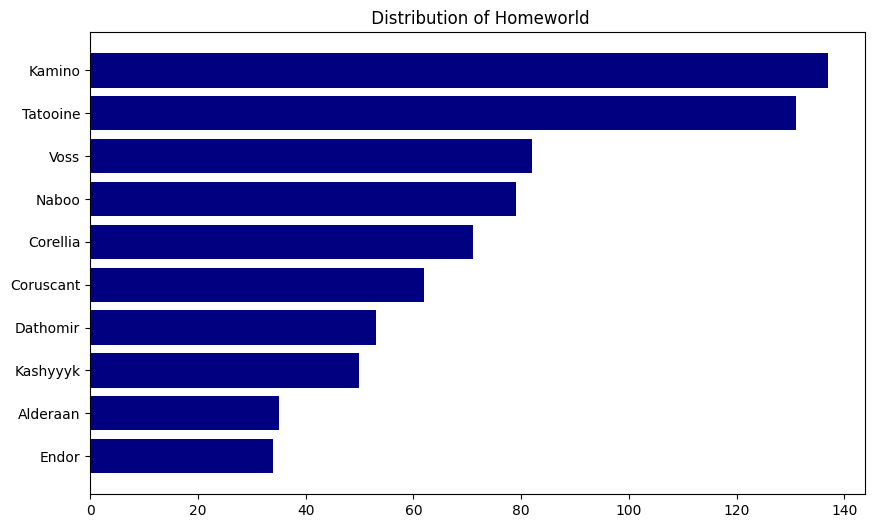

In [21]:
datautils.plot_series_distribution(outliers_data["Homeworld"].dropna().astype(str))

Majority of outliers are human male.

Kamino was the homeworld for clones, which were created on the order of Galactic Republic. Most of the clones didn't even have names, just generic numbers.

Tatooine is a home planet of Leia and Anakin Skywalker, where a lot of early action took place. That's most likely the reason why so many outliers come from that planet.

Voss is a planet which was in interest of both Sith Empire and Galactic Republic, who seeked alliance with Voss tribe to benefit from the visions of their mystics in the war. Again, a lot of action took place there.

Naboo was the birthplace of the Dark Lord of the Sith Sheev Palpatine. Because of that it was pushed as a forefront of galactic politics.

More planets could be analyzed, yet at this point the pattern is clear. Outliers appear at places of significant importance for the Star Wars Universe. When a lot of action takes place in a particular location (planet), there is a need to introduce extra characters that are easy to describe in a fandom article.

## Analysis of universe based on canonical movies

In [22]:
episodes = [
    "Star_Wars:_Episode_I_The_Phantom_Menace",
    "Star_Wars:_Episode_II_Attack_of_the_Clones",
    "Star_Wars:_Episode_III_Revenge_of_the_Sith",
    "Star_Wars:_Episode_IV_A_New_Hope",
    "Star_Wars:_Episode_V_The_Empire_Strikes_Back",
    "Star_Wars:_Episode_VI_Return_of_the_Jedi",
    "Star_Wars:_Episode_VII_The_Force_Awakens",
    "Star_Wars:_Episode_VIII_The_Last_Jedi",
    "Star_Wars:_Episode_IX_The_Rise_of_Skywalker",
]

characters_in_episodes = []

for _, char in data.iterrows():
    # iterate over records
    for crosslink in char.Crosslinks:
        if crosslink in episodes:
            # append only characters which have crosslink to one of the episodes
            characters_in_episodes.append(char.Name)
            break

episodes_characters_data = data.loc[data['Name'].isin(characters_in_episodes)]
episodes_characters_data.head()

Name          DisplayName  \
5                 1047                 1047   
7   1138_(First_Order)  1138  (First Order)   
28               4/163                4/163   
30               5/373                5/373   
32               6/298                6/298   

                                              Content  \
5   1047 was a Human male stormtrooper who served ...   
7   1138 was a human male stormtrooper who served ...   
28  CT-4/163 was a clone trooper in the Grand Army...   
30  5/373 was a clone trooper in the Grand Army of...   
32  6/298 was a clone trooper in the Grand Army of...   

                                           Crosslinks Species Gender  \
5   [Star_Wars_Legends, Wookieepedia:Good_articles...   Human   Male   
7   [Canon, 1138, Special:Upload, Human, Gender, F...   Human   Male   
28  [Star_Wars_Legends, Kamino/Legends, Human/Lege...   Human   Male   
30  [Star_Wars_Legends, Wookieepedia:Sourcing, Spe...   Human   Male   
32  [Star_Wars_Legends, Kamino/Legends, 32_BBY/Leg...   Human   Male   

                                       Affiliation(s) Homeworld Died  
5     [Galactic Empire, Zeta Squadron, Zeta Squadron]       NaN  NaN  
7   [First Order, Stormtrooper Corps, Stormtrooper...       NaN  NaN  
28  [Galactic Republic, Grand Army of the Republic...    Kamino  NaN  
30  [Galactic RepublicGrand Army of the Republic, ...    Kamino  NaN  
32  [Galactic Republic, Grand Army of the Republic...    Kamino  NaN

In [23]:
if os.path.exists(GRAPH_EPISODES_PATH):
    with open(GRAPH_EPISODES_PATH, 'rb') as f:
        universe_episodes = pickle.load(f)
else:
    universe_episodes = graph.create_directed_graph(episodes_characters_data)

    with open(GRAPH_EPISODES_PATH, 'wb') as f:
        pickle.dump(universe_episodes, f)

==================== Universe stats ====================

In degree: {'mean': 4.605247641509434, 'median': 1.0, 'mode': 0, 'min': 0, 'max': 450}
Out degree: {'mean': 4.605247641509434, 'median': 2.0, 'mode': 0, 'min': 0, 'max': 190}
Number of nodes: 3392
Number of edges: 15621
==================== Largest connected component stats ====================

Number of nodes: 2276
Number of edges: 10438


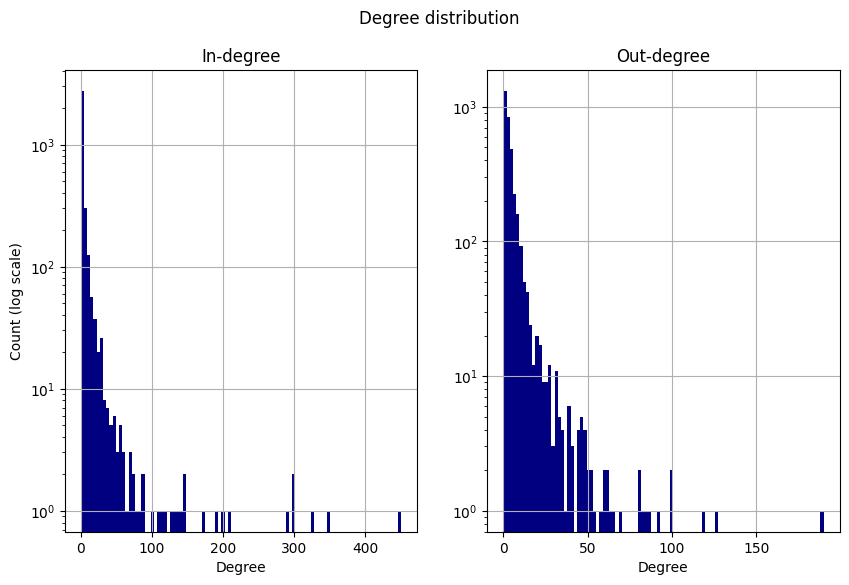

In [24]:
style.print_header("Universe stats")
print(f"In degree: {graph.calc_stats(universe_episodes.in_degree())}")
print(f"Out degree: {graph.calc_stats(universe_episodes.out_degree())}")
print(f"Number of nodes: {len(universe_episodes.nodes)}")
print(f"Number of edges: {len(universe_episodes.edges)}")
_ = graph.plot_degree_distribution(universe_episodes, scale="log")

# Get the largest connected component and transform to undirected graph
universe_episodes = graph.connected_components(universe_episodes)
universe_episodes = universe_episodes.to_undirected()

style.print_header("Largest connected component stats")
print(f"Number of nodes: {len(universe_episodes.nodes)}")
print(f"Number of edges: {len(universe_episodes.edges)}")

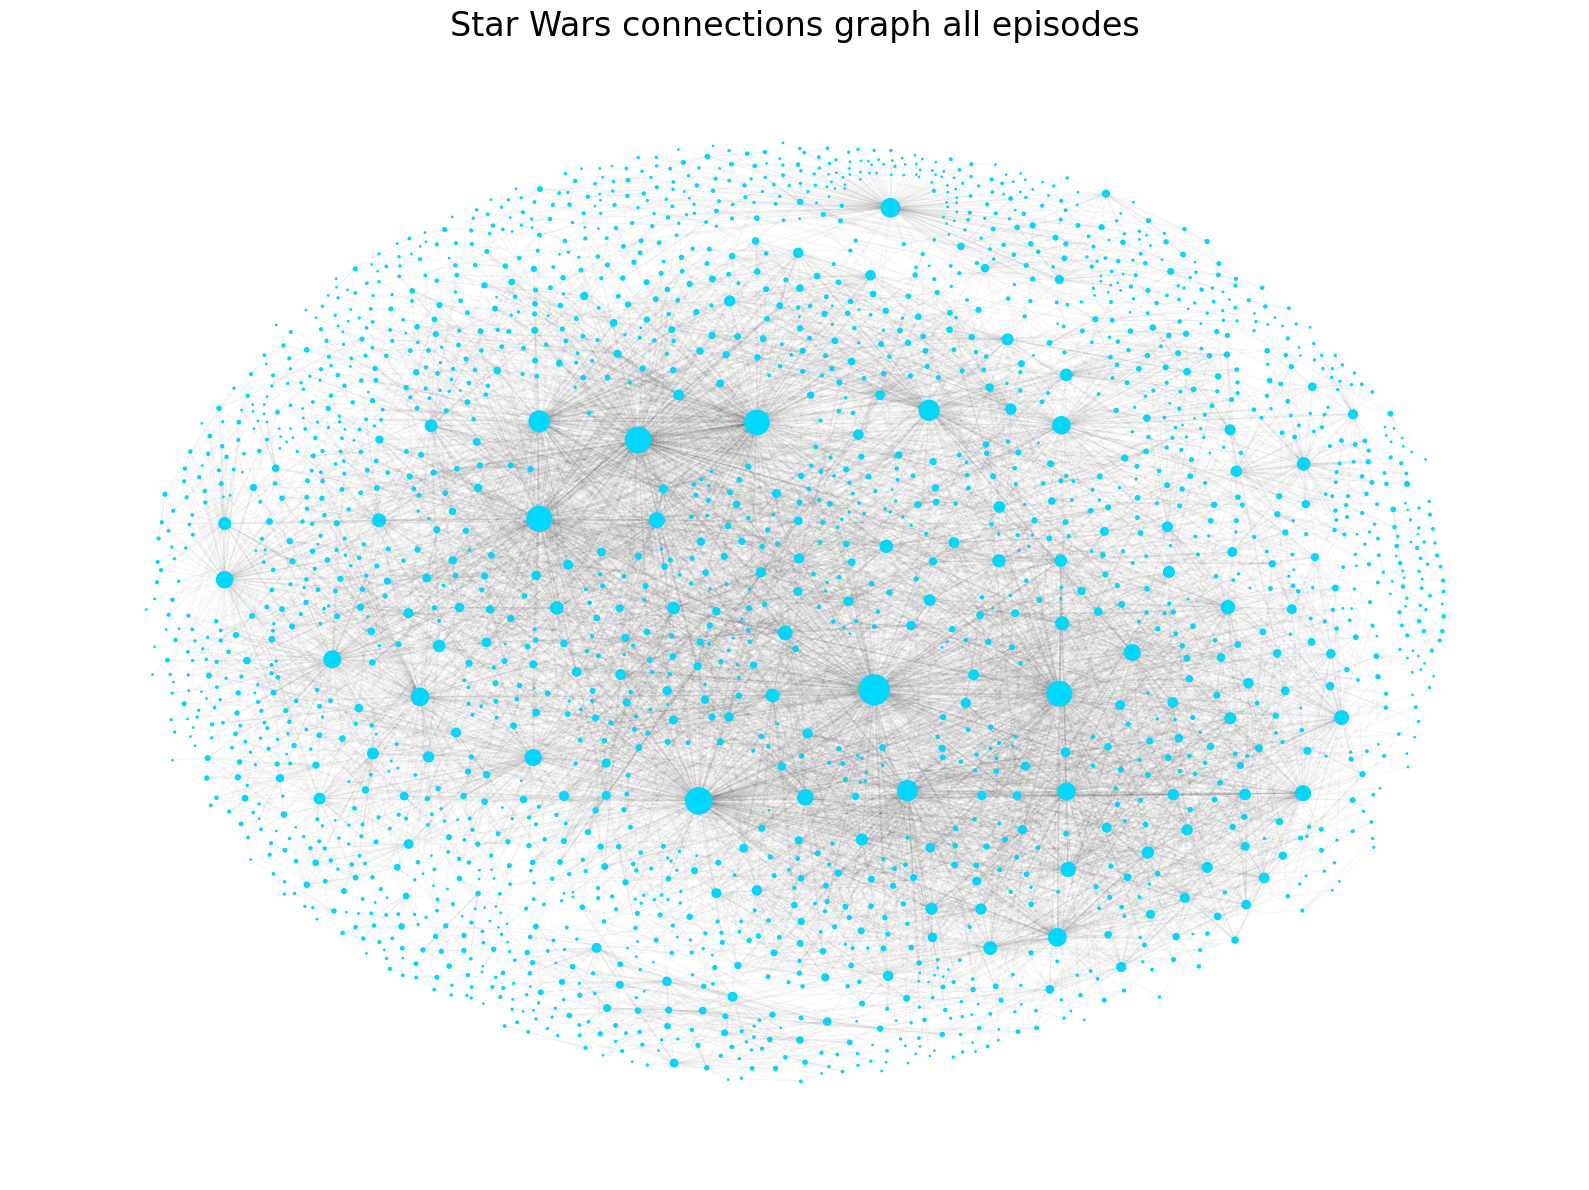

In [25]:
# use Force Atlas 2
# load pickle with pre-calculated positions if present
if os.path.exists(FA_POSITIONS_EPISODES):
    with open(FA_POSITIONS_EPISODES, "rb") as rbfile:
        positions = pickle.load(rbfile)
else:
    positions = fa2.ForceAtlas2(strongGravityMode=True).forceatlas2_networkx_layout(universe_episodes, pos=None, iterations=2000)
    # save to pickle for later use
    with open(FA_POSITIONS_EPISODES, "wb") as wbfile:
        pickle.dump(positions, wbfile)

_ = graph.plot_graph_with_positons(
    universe_episodes,
    positions,
    "Star Wars connections graph all episodes",
    node_alpha=1,
    edge_alpha=0.033,
    figsize=style.LARGE_FIGSIZE,
)
plt.show()

### Finding communities

Graph modularity 0.56


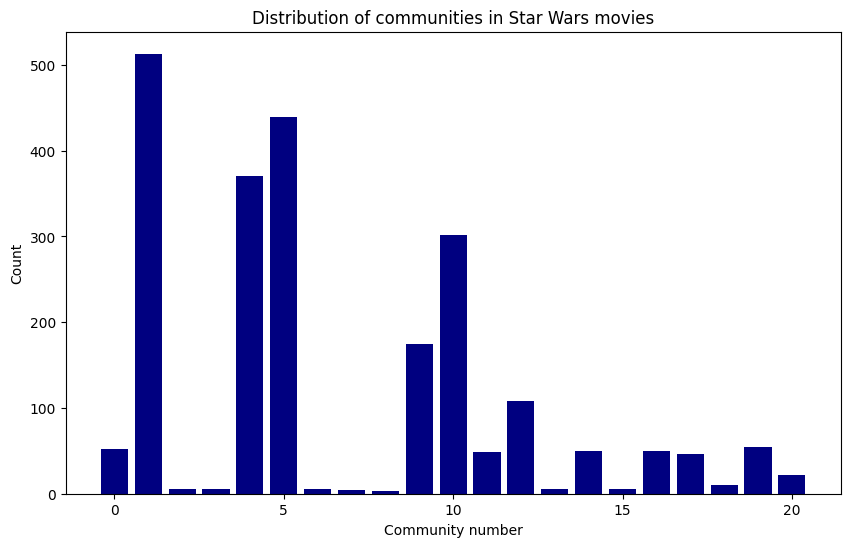

In [26]:
# find communities and its properties
partition, communities, mod = graph.find_communities(universe_episodes)
most_comm_communities = communities.most_common(10)
print(f"Graph modularity {mod:.2f}")
graph.plot_distribution(
    communities.keys(),
    communities.values(),
    title="Distribution of communities in Star Wars movies",
    xlabel="Community number",
)
plt.show()

### Visualization of canonical movies universe

In [27]:
top_characters_in_community = [""] * len(communities)

for name, community_no in partition.items():
    character = top_characters_in_community[community_no]
    if not character or universe_episodes.degree(name) > universe_episodes.degree(character):
       top_characters_in_community[community_no] = name

labels = [(name, style.initials(data[data.Name == name].DisplayName.values[0])) for name in top_characters_in_community]
mapping = {name: data[data.Name == name].DisplayName.values[0] for name in top_characters_in_community}

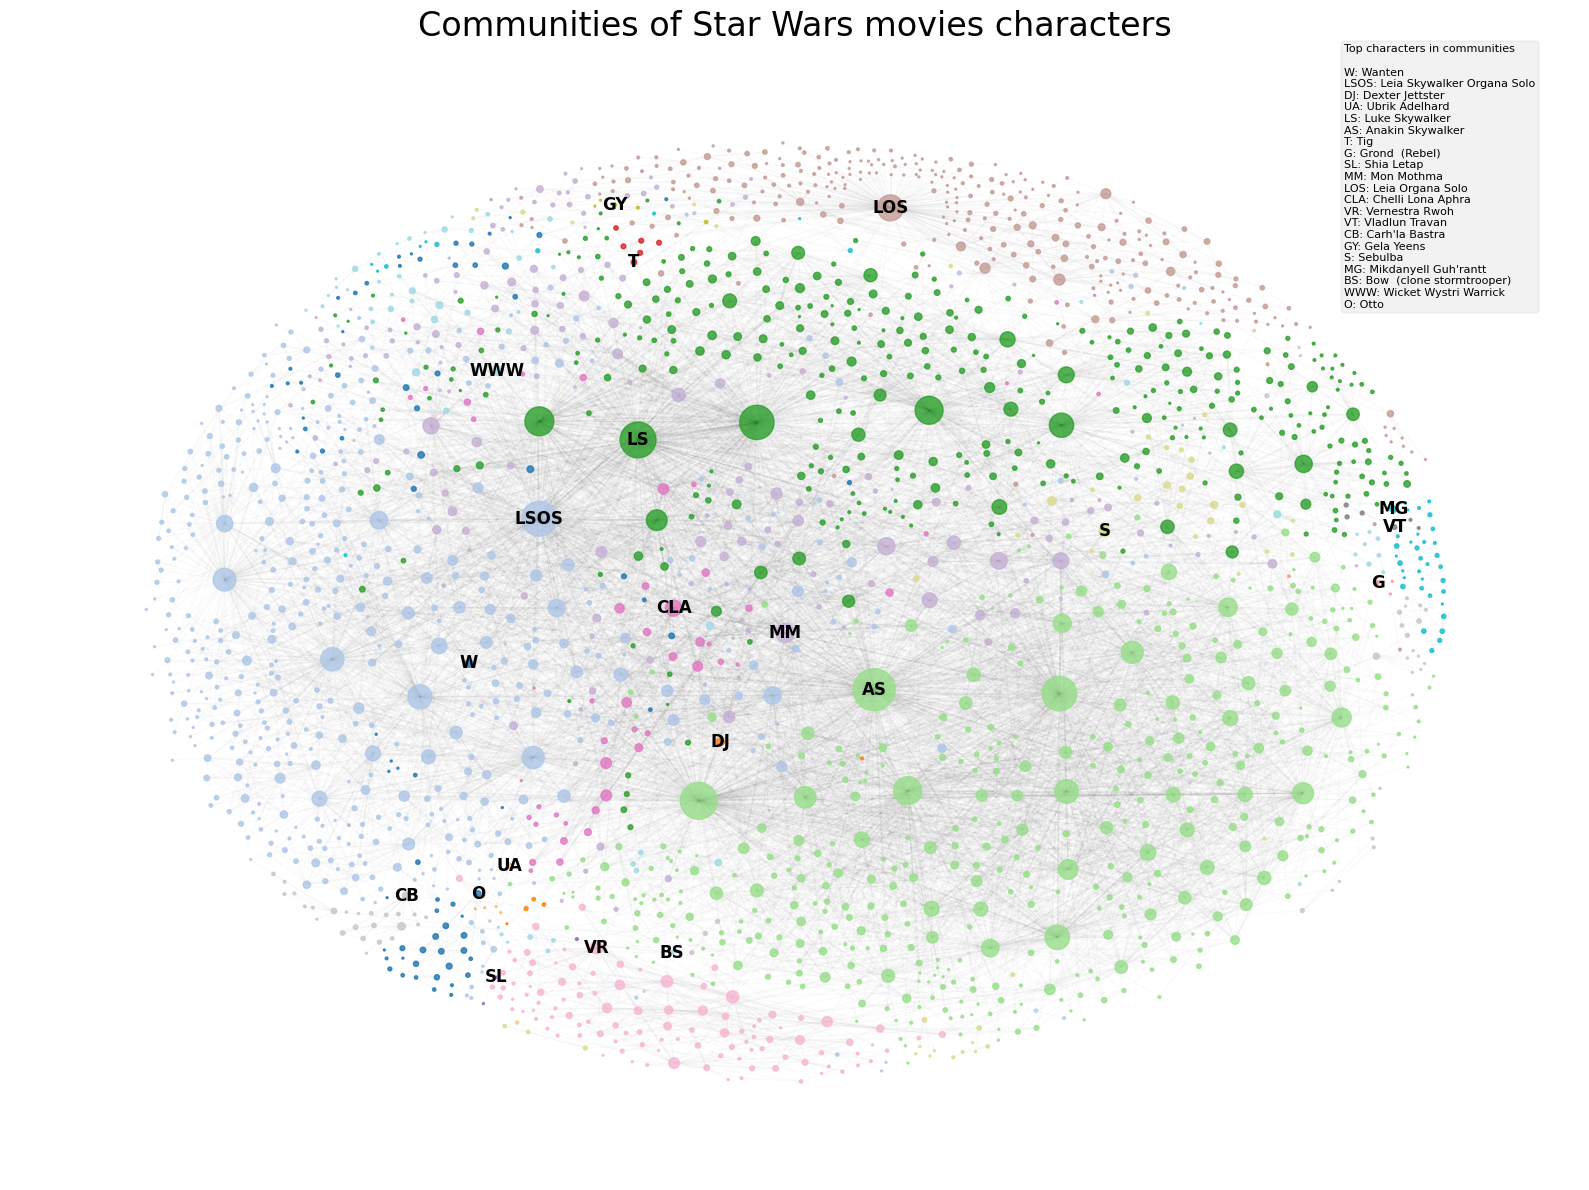

In [29]:
# prepare color map
cmap = cm.get_cmap("tab20", max(partition.values()) + 1)
cmap.N += 1
cmap.colors = np.concatenate((cmap.colors, np.array([colors.to_rgba(style.Color.TORCH_RED)])))

ax = graph.plot_graph_with_positons(
    universe_episodes,
    positions,
    "Communities of Star Wars movies characters",
    figsize=style.LARGE_FIGSIZE,
    node_color=list(partition.values()),
    cmap=cmap,
    node_size_factor=2,
    labels=dict(labels),
    edge_alpha=0.02,
    label_font_size=12
)

props = dict(boxstyle="round", facecolor=style.Color.BLACK, alpha=0.05)

text_initials = "\n".join(
    f"{initials}: {mapping[name]}" for (name, initials) in labels
)
text_initials = "Top characters in communities\n\n" + text_initials
ax.text(0.85, 1, text_initials, transform=ax.transAxes, fontsize=8, verticalalignment="top", bbox=props);
plt.show()

Number of nodes per community

In [30]:
for community_no, nodes_no in communities.items():
    print(f"Community {community_no:4d}, nodes: {nodes_no:4d}, largest hub: {mapping[top_characters_in_community[community_no]]}")

Community    0, nodes:   52, largest hub: Wanten
Community    1, nodes:  513, largest hub: Leia Skywalker Organa Solo
Community    4, nodes:  370, largest hub: Luke Skywalker
Community    5, nodes:  439, largest hub: Anakin Skywalker
Community    9, nodes:  175, largest hub: Mon Mothma
Community   10, nodes:  302, largest hub: Leia Organa Solo
Community   12, nodes:  108, largest hub: Vernestra Rwoh
Community   11, nodes:   49, largest hub: Chelli Lona Aphra
Community   16, nodes:   50, largest hub: Sebulba
Community   17, nodes:   46, largest hub: Mikdanyell Guh'rantt
Community   19, nodes:   55, largest hub: Wicket Wystri Warrick
Community   14, nodes:   50, largest hub: Carh'la Bastra
Community   13, nodes:    6, largest hub: Vladlun Travan
Community   15, nodes:    5, largest hub: Gela Yeens
Community   18, nodes:   10, largest hub: Bow  (clone stormtrooper)
Community   20, nodes:   22, largest hub: Otto
Community    2, nodes:    6, largest hub: Dexter Jettster
Community    3, node

### Generate Word Cloud from Term Frequency - Inverse TermFrequency (TFIDF)

In [31]:
# calculate term frequency for characters that occur in Episodes
tokens = (token for text in episodes_characters_data.Content for token in nltk.word_tokenize(text))
tokens = sentiment.SentimentAnalyzer.normalize_text(tokens)

term_freqs = sentiment.term_freq(tokens)

In [32]:
# calculate inverse term freq for all texts
texts = [sentiment.SentimentAnalyzer.normalize_text(nltk.word_tokenize(content)) for content in data.Content]
idf = sentiment.inv_doc_freq(texts)

tfidf = {}
for term, freq in term_freqs.items():
    tfidf[term] = freq * idf.get(term, 1)

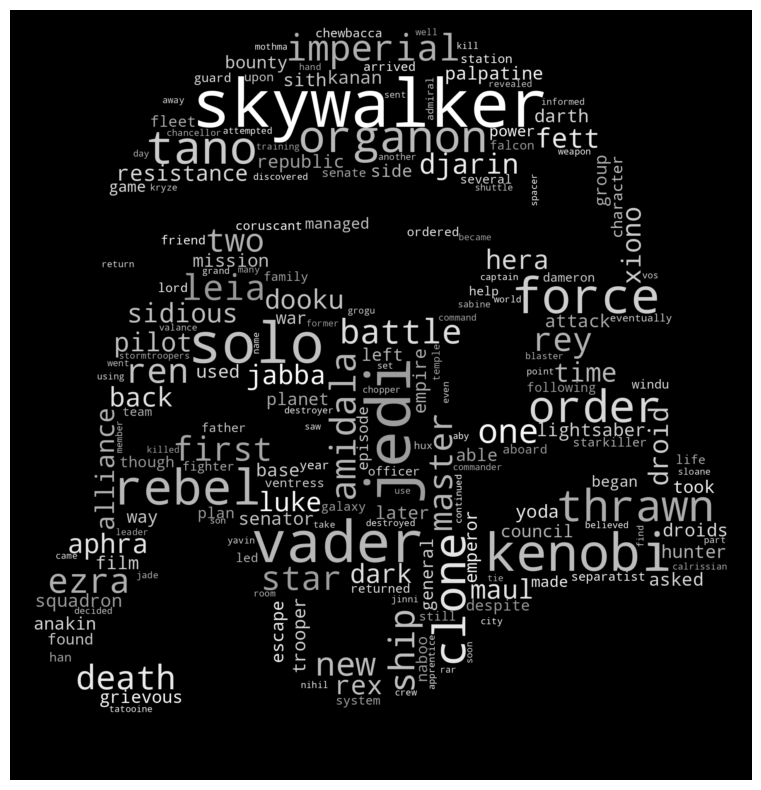

In [33]:
# visualize words in a storm trooper style
mask = 255 - np.array(Image.open("images/stormtrooper.png"))
def _grey_color_func(
    word,
    font_size,
    position,
    orientation,
    random_state=None,
    **kwargs,
):
    return f"hsl(0, 0%, {random.randint(60, 100):d}%)"

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
wordcloud = WordCloud(
    collocations=False,
    background_color="black",
    colormap="inferno",
    height=1024,
    mask=mask,
).generate_from_frequencies(tfidf)

ax.imshow(wordcloud.recolor(color_func=_grey_color_func), interpolation="bilinear")
ax.axis("off")
plt.show()

### Communities for separate movies

Number of characters in movie 1: 366
Number of characters in movie 2: 423
Number of characters in movie 3: 409
Number of characters in movie 4: 1467
Number of characters in movie 5: 372
Number of characters in movie 6: 538


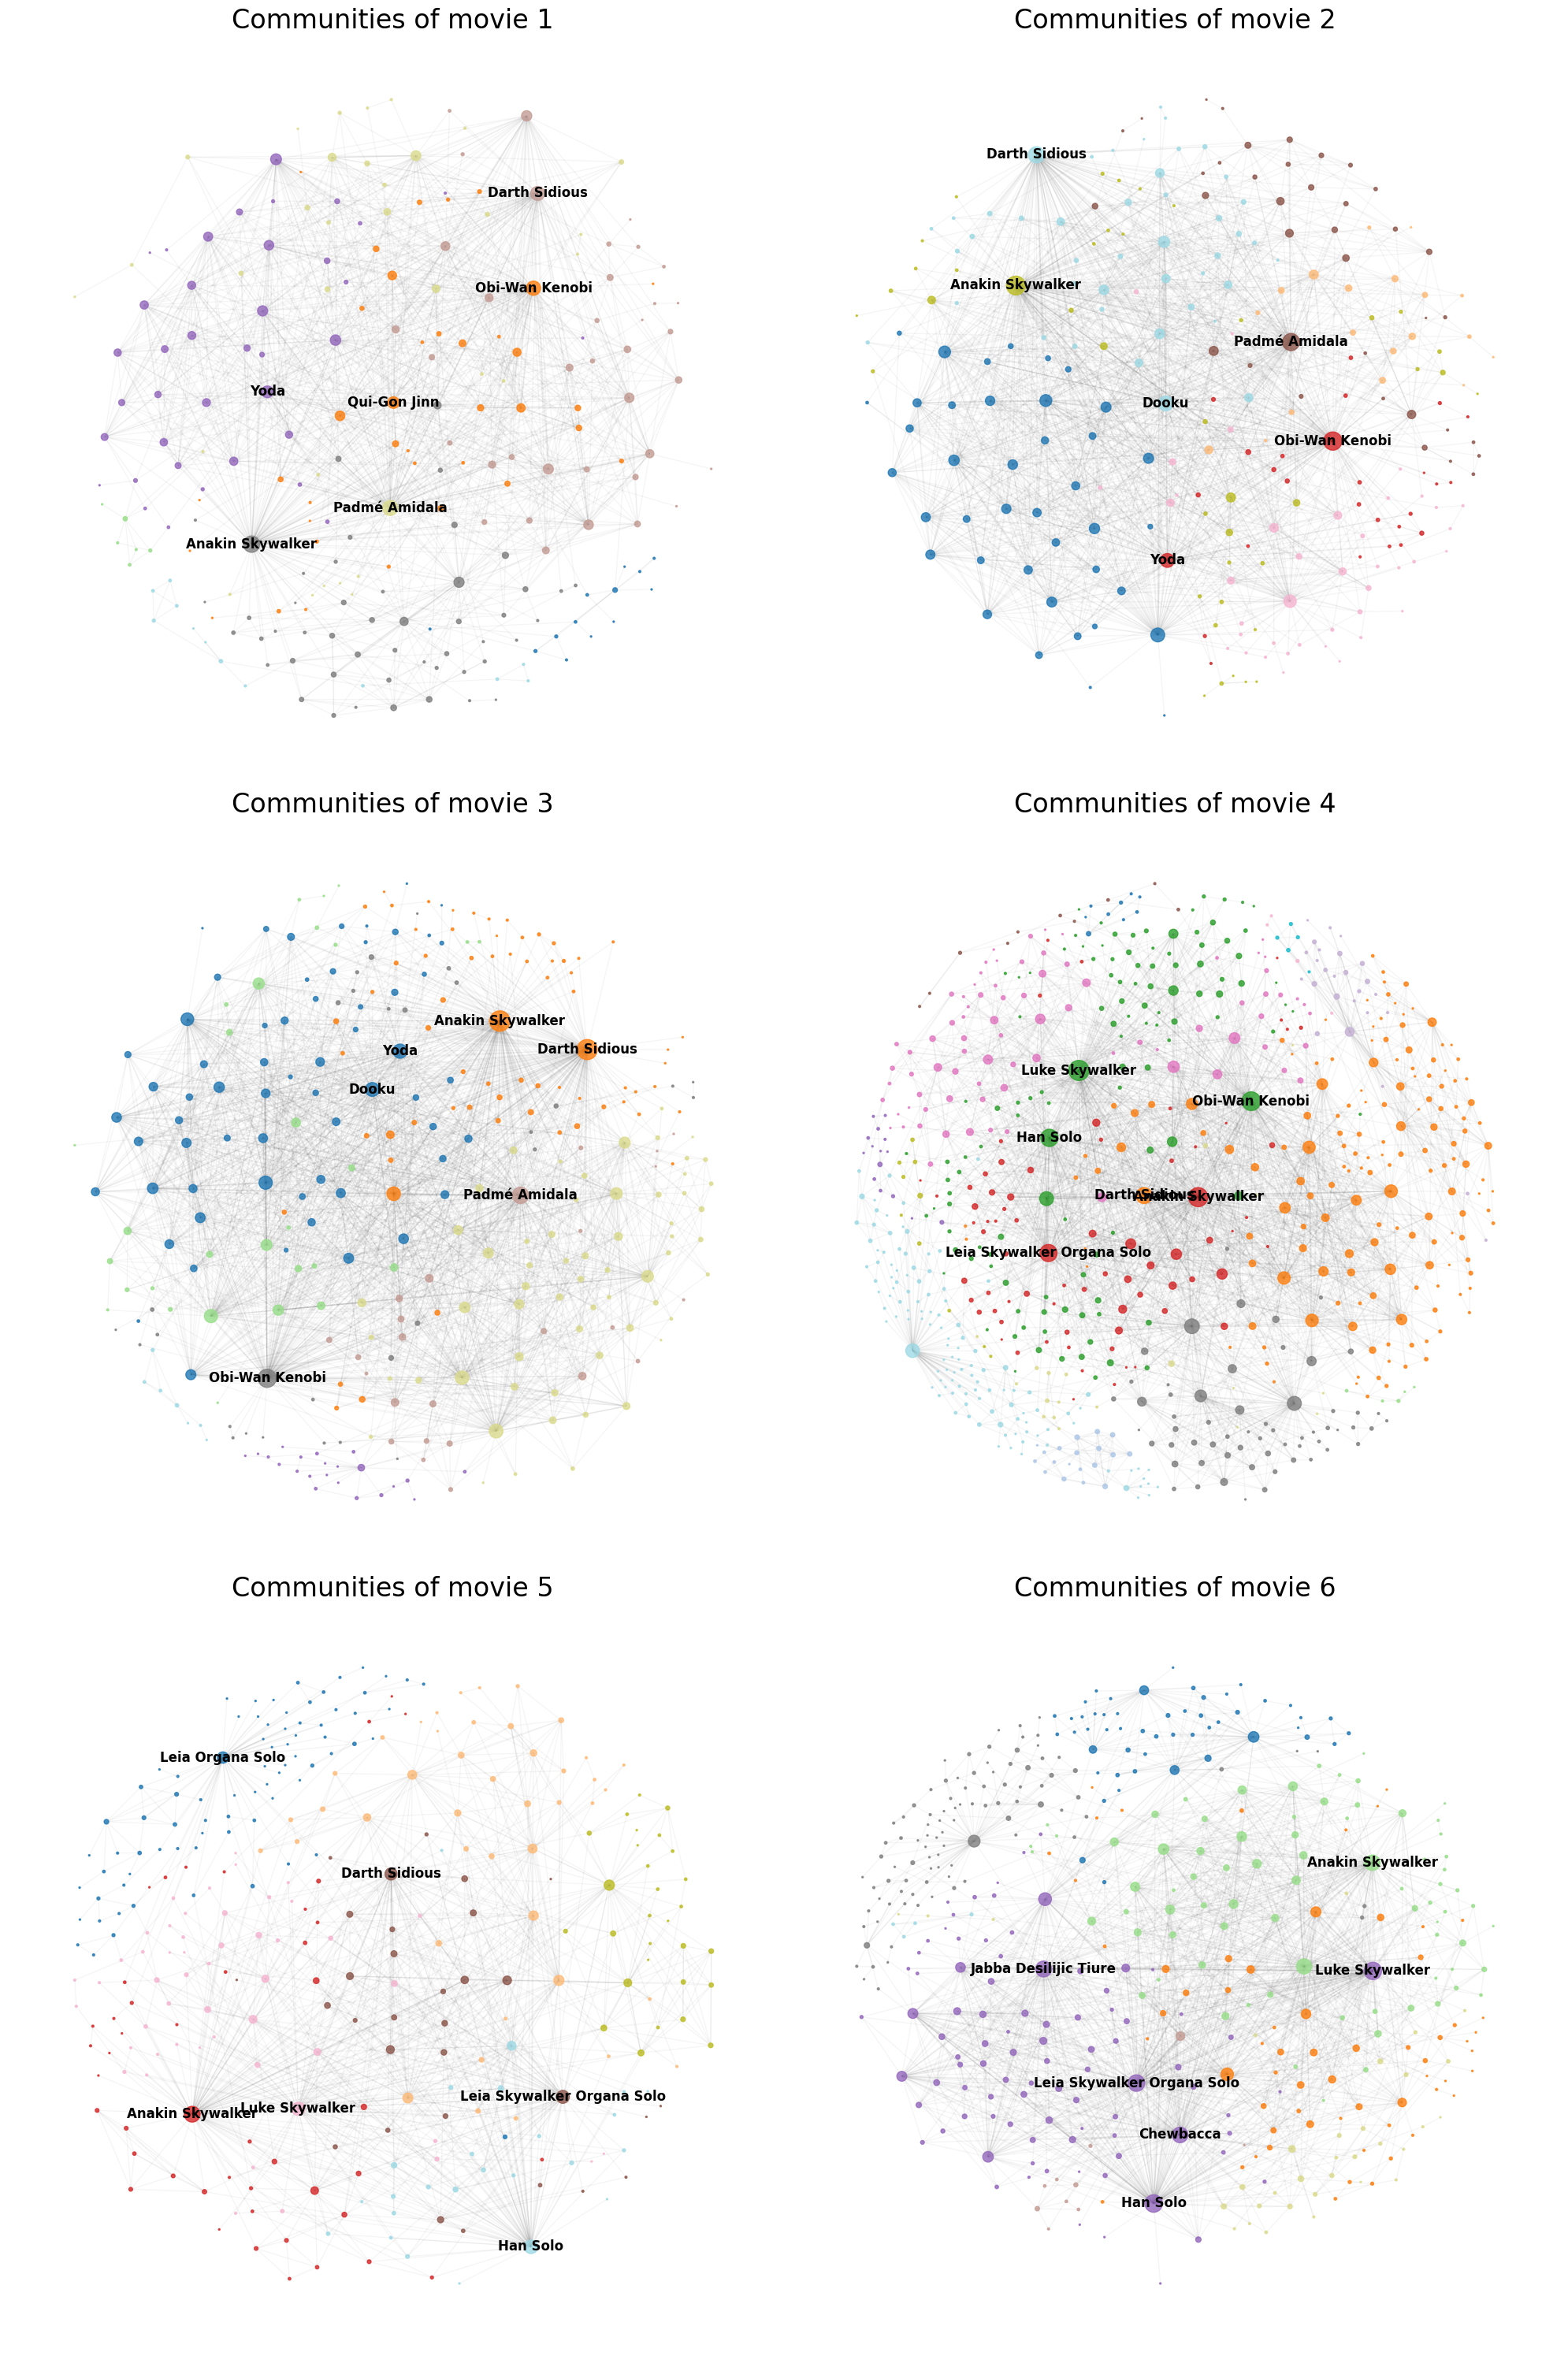

In [81]:
fig, ax = plt.subplots(3,2, figsize = (20,30))

fa_positions_path_tmpl= "graph/fa_positions_ep{}.pickle"
for i in range(6):
    # find characters from matching episode
    characters_in_episodes = datautils.find_rows_with(episodes[i], data, lookup_column="Crosslinks", match_column="Name")
    # filter dataframe with found characters
    episode_data = data.loc[data['Name'].isin(characters_in_episodes)] 

    print(f'Number of characters in movie {i + 1}: {len(episode_data)}')

    # calculate largest connected component
    episode_graph = graph.connected_components(graph.create_directed_graph(episode_data)).to_undirected()

    fa_positions_path = fa_positions_path_tmpl.format(i+1)
    if os.path.exists(fa_positions_path):
        # load positions if they already exist for consistency
        with open(fa_positions_path, "rb") as rbfile:
            positions_episode = pickle.load(rbfile)
    else:
        # calculate graph positions for an undirected graph
        positions_episode = fa2.ForceAtlas2(
            strongGravityMode=True,
            verbose=False
        ).forceatlas2_networkx_layout(episode_graph, pos=None, iterations=2000)
        # save positions for later use
        with open(fa_positions_path, "wb") as wbfile:
            pickle.dump(positions_episode, wbfile)

    # find communities and its properties
    partition, communities, mod = graph.find_communities(episode_graph)
    # use tab20 colormap
    cmap = cm.get_cmap("tab20", max(partition.values()) + 1)
    # add labels for three largest hubs
    node_degrees = sorted(episode_graph.degree, key=lambda x: x[1], reverse=True)
    labels = [(name[0], episode_data[episode_data.Name == name[0]].DisplayName.values[0]) for name in node_degrees[:6]]

    graph.plot_graph_with_positons(
        episode_graph,
        positions_episode,
        f"Communities of movie {i+1}",
        node_color=list(partition.values()),
        cmap=cmap,
        node_size_factor=2,
        edge_alpha=0.04,
        label_font_size=12,
        ax=ax[int(np.floor(i/2)), i%2],
        labels=dict(labels)
        )
plt.show()

## Sentiment analysis

Average sentiment of all characters:		 5.42
10th percentile of sentiment of all characters:	 5.04
90th percentile of sentiment of all characters:	 5.80


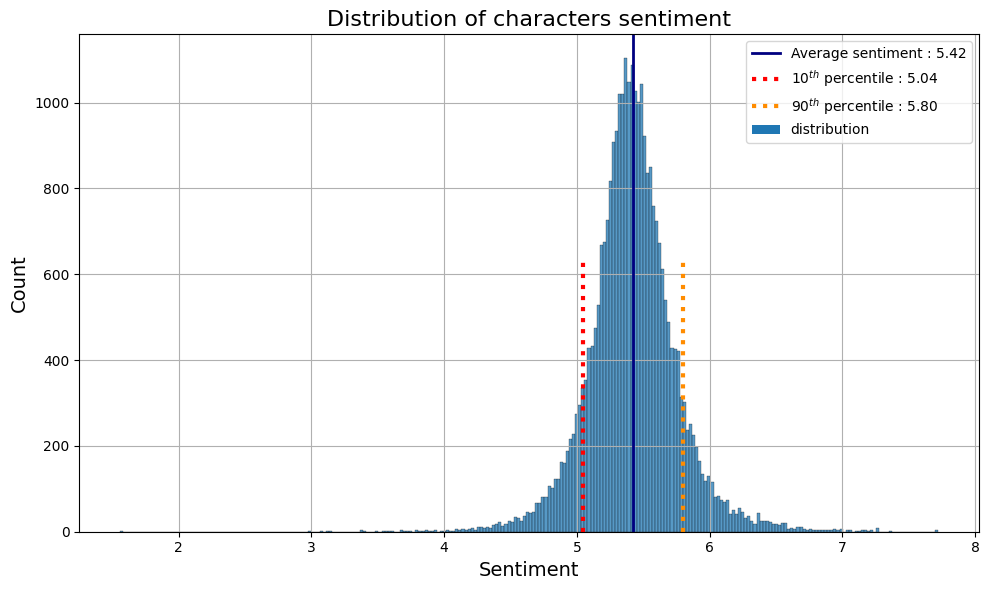

In [35]:
# load data into sentiment analyzer
sentiment_analyzer = sentiment.SentimentAnalyzer()
sentiment_analyzer.load_sentiment_data("data/wordlist.txt")
sentiment_analyzer.data.head()

# add Sentiment column to data frame
# since calculating sentiment for each record takes long
# data has been saved to pickle
if not os.path.exists(SENTIMENT_DATA_PATH):
    sentiments = []

    for i, row in data.iterrows():
        tokens = nltk.word_tokenize(row.Content)
        tokens = sentiment_analyzer.normalize_text(tokens)
        sentiments.append(sentiment_analyzer.calc_sentiment(tokens))

    data["Sentiment"] = sentiments

    with open(SENTIMENT_DATA_PATH, "wb") as wbfile:
        pickle.dump(data, wbfile)
else:
    with open(SENTIMENT_DATA_PATH, "rb") as rbfile:
        data = pickle.load(rbfile)

# remove records without sentiment
data = data[data.Sentiment > 0]
mean_sentiment = data.Sentiment.mean()
percentile10 = data.Sentiment.quantile(0.1)
percentile90 = data.Sentiment.quantile(0.9)

print(f"Average sentiment of all characters:\t\t {mean_sentiment:.2f}")
print(f"10th percentile of sentiment of all characters:\t {percentile10:.2f}")
print(f"90th percentile of sentiment of all characters:\t {percentile90:.2f}")

fig, ax = plt.subplots(1, 1, figsize=style.DEFAULT_FIGSIZE)

datautils.plot_distribution(
    data.Sentiment, fig=fig, ax=ax,
    title="Distribution of characters sentiment",
    xlabel="Sentiment",
    ylabel="Count",
)
plt.show()

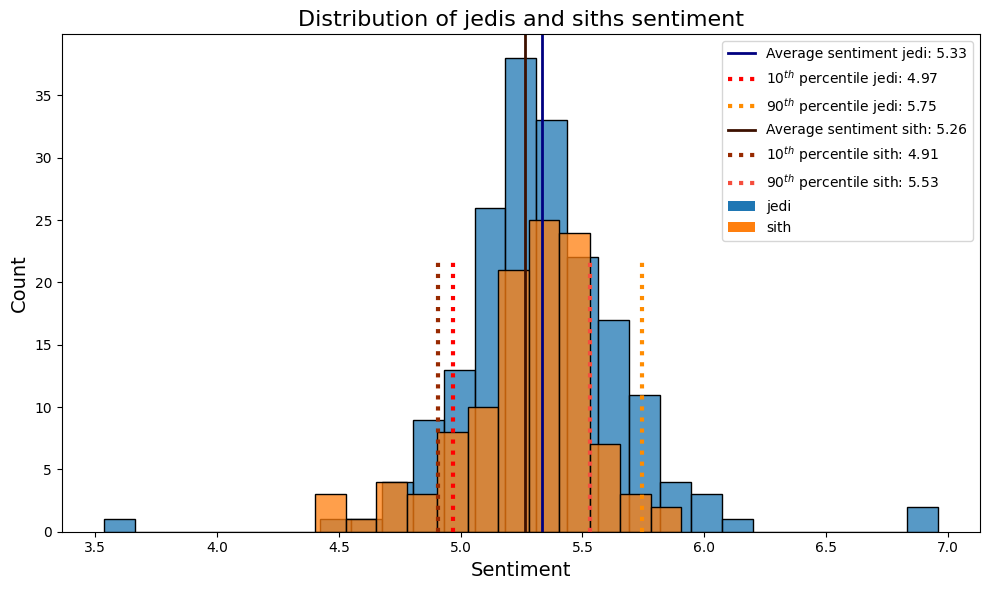

In [36]:
# Plot distribution of jedi and sith sentiment
siths = []
jedis = []

for _, row in data[~data["Affiliation(s)"].isna()].iterrows():
    for affiliation in row["Affiliation(s)"]:
        if re.search("sith", row.Name.lower()):
            siths.append(row.Name)
        if re.search("jedi", row.Name.lower()):
            jedis.append(row.Name)

data_sith = data[data.Name.isin(siths)]
data_jedi = data[data.Name.isin(jedis)]

fig, ax = plt.subplots(1, 1, figsize=style.DEFAULT_FIGSIZE)

fig, ax = datautils.plot_distribution(
    data_jedi.Sentiment, fig=fig, ax=ax,
    xlabel="Sentiment",
    ylabel="Count",
    tag="jedi",
)
fig, ax = datautils.plot_distribution(
    data_sith.Sentiment, fig=fig, ax=ax,
    title="Distribution of jedis and siths sentiment",
    xlabel="Sentiment",
    ylabel="Count",
    tag="sith",
    mean_color=style.Color.SEAL_BROWN,
    percentile10_color=style.Color.SADDLE_BROWN,
    percentile90_color=style.Color.SUNSET_ORANGE,
)
plt.show()

### Jedi outlier analysis

It can be clearly seen at the plot, that few jedi have extremely low or high sentiment. In this section analysis of those outliers is performed.

#### Low sentiment

In [60]:
jedi_sentiments = data_jedi.sort_values(by="Sentiment")

print(f"Name:\t\t\t\t\t{jedi_sentiments.iloc[0].DisplayName}")
print(f"Text on character page:\t\t\t{jedi_sentiments.iloc[0].Content}")

# find words that are present in wordlist data set
tokens = nltk.word_tokenize(jedi_sentiments.iloc[0].Content)
tokens = sentiment_analyzer.normalize_text(tokens)
print(f"Words and corresponding sentiment:\t{sentiment_analyzer.in_wordlist(tokens)}")

Name:					Unidentified Human male Jedi  (Jabiim)
Text on character page:			This Human Jedi fought in the Battle of Jabiim during the Clone Wars.
Words and corresponding sentiment:	{'human': 6.26, 'fought': 3.1, 'battle': 2.98, 'war': 1.8}


#### High sentiment

In [67]:
for _, row in jedi_sentiments.iloc[-2:].iterrows():
    tokens = nltk.word_tokenize(row.Content)
    tokens = sentiment_analyzer.normalize_text(tokens)
    print(f"Name: {row.DisplayName}")
    print(f"Text on character page: {row.Content}")
    print(f"Words and corresponding sentiment: {sentiment_analyzer.in_wordlist(tokens)}")
    print()

Name: Unidentified blue-skinned Jedi  (Mace Windu)
Text on character page: A Nautolan Jedi discovered Mace Windu as an infant.
Words and corresponding sentiment: {'discovered': 7.0, 'infant': 6.9}

Name: Unidentified Quarren Jedi student
Text on character page: An unidentified Quarren Jedi student was a trainee at the Jedi Praxeum on Yavin 4. He was present at the Jedi wedding of Luke Skywalker and Mara Jade.
Words and corresponding sentiment: {'student': 6.58, 'present': 6.96, 'wedding': 7.34}



### Anakin case study

Anakin Skywalker is particularly interesting character. Not only is he the main character of the canonical saga, but also his sentiment changed significantly throughout the saga. At the beginning he was the hope of New Republic, which was very positive organization. At some point, he turned into a Darth Vader. A sith lord that helped the Empire, source of absolute evil, to take control and Destroy Galaxy. Only in the end, a few moments before his death, he redeemed himself.

Everything has been described chronologically in the [Wookiepedia](https://starwars.fandom.com/wiki/Anakin_Skywalker) article. In this analysis the attempt has been made to come to similar conclusions of a character shift based purely on the article's content. 

In [39]:
# Extract the content separately for Anakin Skywalker and Darth Vader periods.
anakin = data[data.Name == "Anakin_Skywalker"]
anakin_page_content = anakin.Content.values[0]

anakin_begin = re.search(r"Believed to have been conceived", anakin_page_content)
anakin_end = re.search(r"The Bad Batch", anakin_page_content)
anakin_content = anakin_page_content[anakin_begin.span()[0]:anakin_end.span()[0]]

darth_vader_begin = re.search(r"At some point before the Battle of Coruscant", anakin_page_content)
darth_vader_end = re.search(r"though unsung to everyone except in the eyes of Luke", anakin_page_content)
darth_vader_content = anakin_page_content[darth_vader_begin.span()[0]:darth_vader_end.span()[0]]

In [76]:
# Anakin Skywalker (should be good)
tokens = nltk.word_tokenize(anakin_content)
tokens = sentiment_analyzer.normalize_text(tokens)
anakin_sentiment = sentiment_analyzer.calc_sentiment(tokens)
print(f"Anakin Sywalker sentiment:{anakin_sentiment:>8.4f}")
# Darth Vader (should be evil)
tokens = nltk.word_tokenize(darth_vader_content)
tokens = sentiment_analyzer.normalize_text(tokens)
darth_vader_sentiment = sentiment_analyzer.calc_sentiment(tokens)
print(f"Darth Vader sentiment:{darth_vader_sentiment:>8.4f}")

Anakin Sywalker sentiment:  5.3212
Darth Vader sentiment:  5.2591


#### Throughout his life

Anakin character was evolving through the 6-episode movie saga. That's why sentiment for each paragraph, that describes different period of his life, has been calculated. The results are plotted on a timeline with critical turnovers marked. 

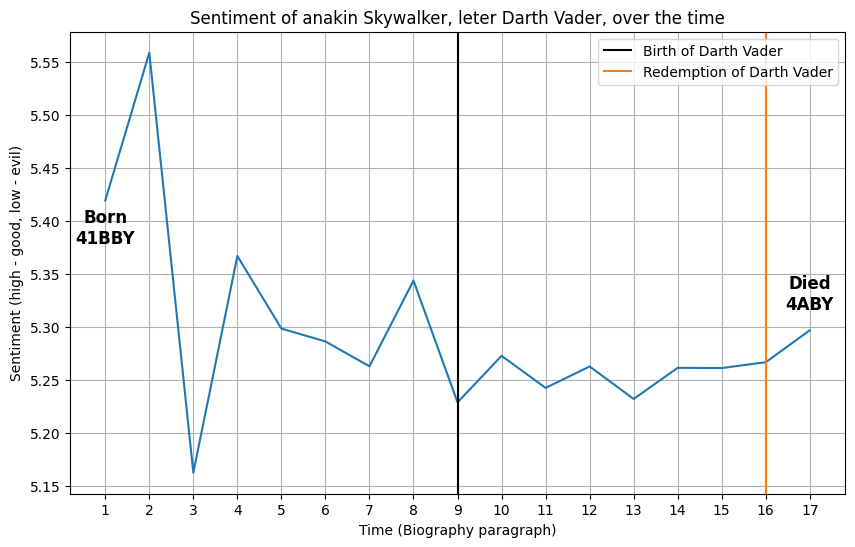

In [41]:
# Set the beginning and end of each paragraph end extract in-between content.
paragraphs = []
paragraphs.append({"begin": r"Believed to have been conceived", "end": r"more important for the medical center to receive it"})
paragraphs.append({"begin": r"One day, at the age of 9,", "end": r"with the death of Jinn, slain by Darth Maul"})
paragraphs.append({"begin": r"However, during the Master's funeral", "end": r"see Amidala for a decade"})
paragraphs.append({"begin": r"As he grew, Skywalker's exceptional skills made", "end": r"Skywalker worked on a RazBohan high-encryption comlink"})
paragraphs.append({"begin": r"Ten years after the Battle of Naboo", "end": r"Skywalker received a cybernetic replacement for his lost arm"})
paragraphs.append({"begin": r"Following the engagement on Geonosis", "end": r"fired gas at its mouth on Palpatine's orders"})
paragraphs.append({"begin": r"Even as the Clone Wars continued with", "end": r" back to the sunrise before he passed away"})
paragraphs.append({"begin": r"When the Jedi Council received a 2,000-year-old", "end": r"Yoda but managed to progress as Yoda taught her some skills"})
paragraphs.append({"begin": r"During the defense of Cato Neimoidia", "end": r"The Bad Batch"})
paragraphs.append({"begin": r"At some point before the Battle of Coruscant", "end": r"man he had become, but knew it was too late to turn back"})
paragraphs.append({"begin": r"Soon thereafter, Vader saw Amidala's star skiff", "end": r"Vader ordered to imprison and torture the people of Mon Cala"})
paragraphs.append({"begin": r"Over the next two decades of the Empire's reign", "end": r"Imperialis, under the watch of two Royal Guards"})
paragraphs.append({"begin": r"Vader at last had a chance for his long-awaited rematch with Kenobi", "end": r"Organa back to her cell to await her execution"})
paragraphs.append({"begin": r"After the scout ships sent to Dantooine found", "end": r"defeat and assured him that the Rebels could never win"})
paragraphs.append({"begin": r"By the time three years had passed after the Battle of Yavin", "end": r"Force to pull him from space, rendering him unconscious and taking him prisoner"})
paragraphs.append({"begin": r"Vader returned to the Executor", "end": r"use in their campaign against the Sith"})
paragraphs.append({"begin": r"Qi'ra's operations against the Sith", "end": r"though unsung to everyone except in the eyes of Luke"})

sentiments = []
for paragraph in paragraphs:
    begin = re.search(paragraph["begin"], anakin_page_content)
    end = re.search(paragraph["end"], anakin_page_content)
    content = anakin_page_content[begin.span()[0]:end.span()[0]]
    tokens = nltk.word_tokenize(content)
    tokens = sentiment_analyzer.normalize_text(tokens)
    sentiments.append(sentiment_analyzer.calc_sentiment(tokens))

fig, ax = plt.subplots(1, 1, figsize=style.DEFAULT_FIGSIZE)
ax.plot(range(1, 18), sentiments)
ax.set_xticks(range(1, 18))
ax.set_title("Sentiment of anakin Skywalker, leter Darth Vader, over the time")
ax.set_xlabel("Time (Biography paragraph)")
ax.set_ylabel("Sentiment (high - good, low - evil)")
ax.axvline(9, label="Birth of Darth Vader", color="black")
ax.axvline(16, label="Redemption of Darth Vader", color="C1")
ax.annotate("Born\n41BBY", (1, sentiments[0]), ha="center", xytext=(1, sentiments[0]-0.04), weight="bold", size=12)
ax.annotate("Died\n4ABY", (17, sentiments[-1]), ha="center", xytext=(17, sentiments[-1]+0.02), weight="bold", size=12)
ax.grid()

ax.legend()
plt.show()

In step 3 paragraph is short, thus the bias.

In step 16 Darth Vader redeemed himself and turned again to Anakin Skywalker.

The plot operates on rather narrow sentiment range (5.16 - 5.55). Nevertheless, it shows the evolution of Anakin's character in accordance with what happened in the movies.